<a href="https://colab.research.google.com/github/submouse9903/uos-deepLearning/blob/main/CH07_VAE(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - AutoEncoder
See https://avandekleut.github.io/vae/

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
        loss_v = loss.to('cpu').detach().numpy()
        print("loss:" , loss_v)
    return autoencoder

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [ ]:
autoencoder = train(autoencoder, data)

 10%|█         | 1/10 [00:08<01:16,  8.52s/it]

loss: 3973.5488


 20%|██        | 2/10 [00:17<01:09,  8.66s/it]

loss: 3804.9993


 30%|███       | 3/10 [00:26<01:01,  8.76s/it]

loss: 3566.9504


 40%|████      | 4/10 [00:34<00:51,  8.61s/it]

loss: 3506.647


 50%|█████     | 5/10 [00:45<00:46,  9.37s/it]

loss: 3229.4353


 60%|██████    | 6/10 [00:54<00:36,  9.19s/it]

loss: 3296.6157


 70%|███████   | 7/10 [01:02<00:27,  9.06s/it]

loss: 3311.137


 80%|████████  | 8/10 [01:10<00:17,  8.75s/it]

loss: 3201.4868


 90%|█████████ | 9/10 [01:19<00:08,  8.78s/it]

loss: 3259.0078


100%|██████████| 10/10 [01:28<00:00,  8.86s/it]

loss: 3138.391


In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=0.5, alpha = 0.5)
        if i > num_batches:
            plt.colorbar()
            break


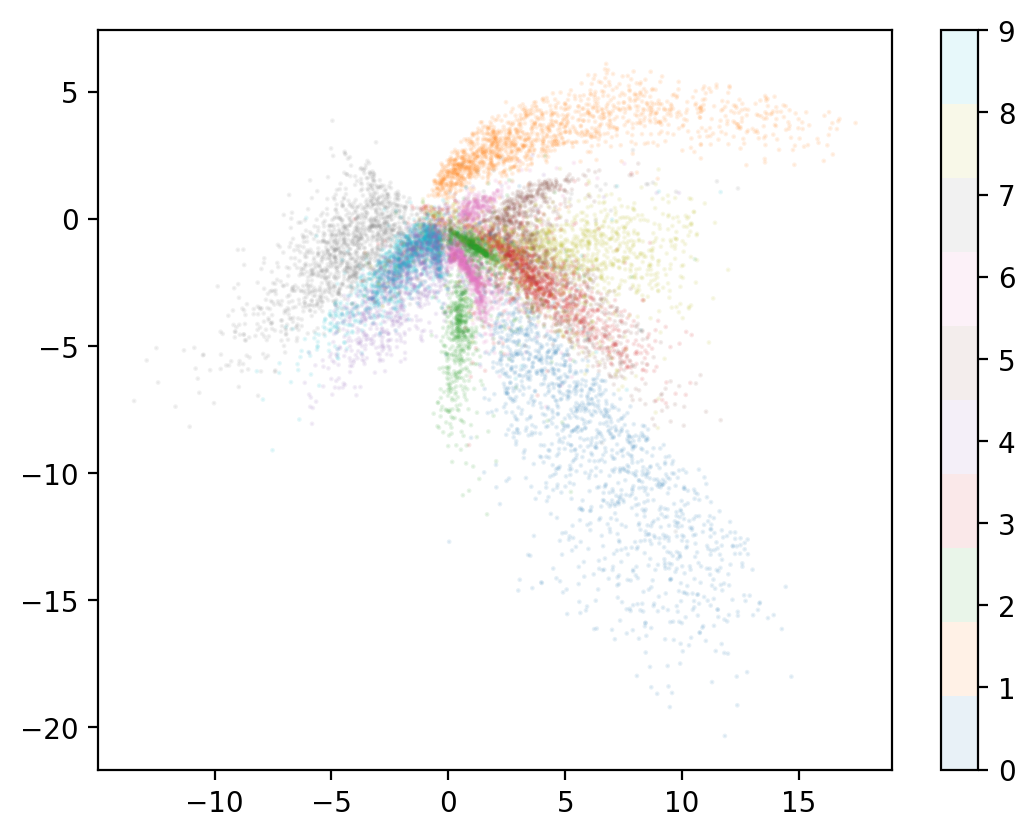

In [ ]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

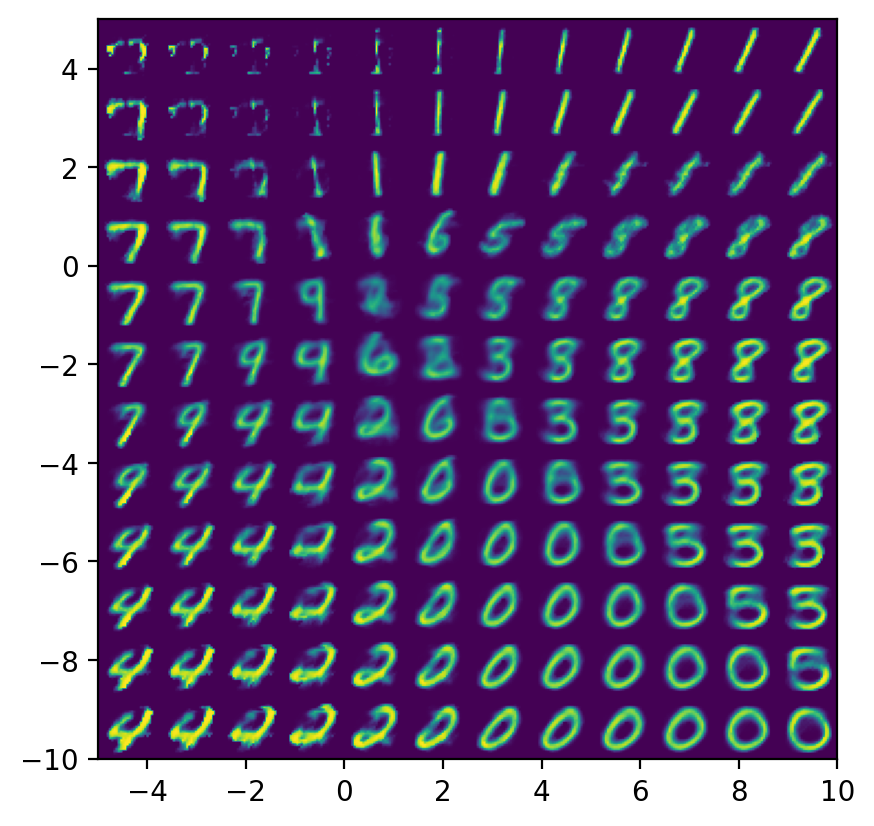

In [ ]:
plot_reconstructed(autoencoder)

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2/2 + mu**2/2 - torch.log(sigma) - 1).sum()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, alpha, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + alpha*autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data, 1)

In [ ]:
plot_latent(vae, data)

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))